In [11]:
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def parse_log_file(file_name, is_sender):
    with open(file_name, 'r') as file:
        log_data = file.readlines()

    parsed_data = {}
    for line in log_data:
        # Use 'sent at' for sender logs and 'received at' for receiver logs
        action = 'sent' if is_sender else 'received'
        match = re.search(f'INFO:root:Job ID: (.*) {action} at (.*), job:', line)
        if match:
            job_id = str(match.group(1))
            timestamp = datetime.datetime.strptime(match.group(2), '%Y-%m-%d %H:%M:%S.%f')
            parsed_data[job_id] = timestamp
        else:
            print(f"Could not parse line: {line}")

    return parsed_data

def combine_and_sort_logs(sender_data, receiver_data):
    combined_data = []

    for job_id, timestamp in sender_data.items():
        combined_data.append(('send', job_id, timestamp))

    for job_id, timestamp in receiver_data.items():
        combined_data.append(('receive', job_id, timestamp))

    # Sort the combined data by timestamp and job ID
    combined_data.sort(key=lambda x: (x[2], x[1]))

    return combined_data

def calculate_latency(combined_data):
    send_times = {}
    latencies = {}

    for action, job_id, timestamp in combined_data:
        if action == 'send':
            send_times[job_id] = timestamp
        elif action == 'receive':
            if job_id in send_times:
                latency = timestamp - send_times[job_id]
                latencies[job_id] = latency
            else:
                print(f"Job ID {job_id} was not sent.")

    return latencies

In [13]:
sender_file = 'sender_log.log'
receiver_file = 'receiver_log.log'
sender_data = parse_log_file('sender_log.log', True)
receiver_data = parse_log_file('receiver_log.log', False)
combined_data = combine_and_sort_logs(sender_data, receiver_data)
latencies = calculate_latency(combined_data)
num_jobs_sent = len(sender_data)
num_jobs_received = len(receiver_data)

# Calculate total latency in seconds
total_latency = sum(latency.total_seconds() for latency in latencies.values())

# Calculate average latency in seconds
average_latency_seconds = total_latency / len(latencies)

# Convert average latency to milliseconds
average_latency_ms = average_latency_seconds * 1000

# Calculate percentiles of latencies
latencies_ms = [latency.total_seconds() * 1000 for latency in latencies.values()]
p50 = np.percentile(latencies_ms, 50)
p95 = np.percentile(latencies_ms, 95)
p99 = np.percentile(latencies_ms, 99)


# Calculate error rate
num_errors = num_jobs_sent - num_jobs_received
error_rate = num_errors / num_jobs_sent

# Calculate throughput
total_time = max(timestamp for _, _, timestamp in combined_data) - min(timestamp for _, _, timestamp in combined_data)
throughput = num_jobs_received / total_time.total_seconds()


# Finding the earliest (start time) and latest (end time) timestamps from the sender and receiver data
start_time_sender = min(sender_data.values()) if sender_data else None
start_time_receiver = min(receiver_data.values()) if receiver_data else None
end_time_sender = max(sender_data.values()) if sender_data else None
end_time_receiver = max(receiver_data.values()) if receiver_data else None

start_time = min(start_time_sender, start_time_receiver) if (start_time_sender and start_time_receiver) else None
end_time = max(end_time_sender, end_time_receiver) if (end_time_sender and end_time_receiver) else None

In [14]:
print(f"Number of jobs sent: {num_jobs_sent}")
print(f"Number of jobs received: {num_jobs_received}")

print(f"Average latency: {average_latency_ms} ms")



print(f"50th percentile latency: {p50} ms")
print(f"95th percentile latency: {p95} ms")
print(f"99th percentile latency: {p99} ms")


print(f"Error rate: {error_rate * 100}%")



print(f"Throughput: {throughput} jobs/sec")

Number of jobs sent: 5000
Number of jobs received: 5000
Average latency: 72.31327460000013 ms
50th percentile latency: 73.982 ms
95th percentile latency: 130.95205 ms
99th percentile latency: 139.12503 ms
Error rate: 0.0%
Throughput: 335.92147392130744 jobs/sec


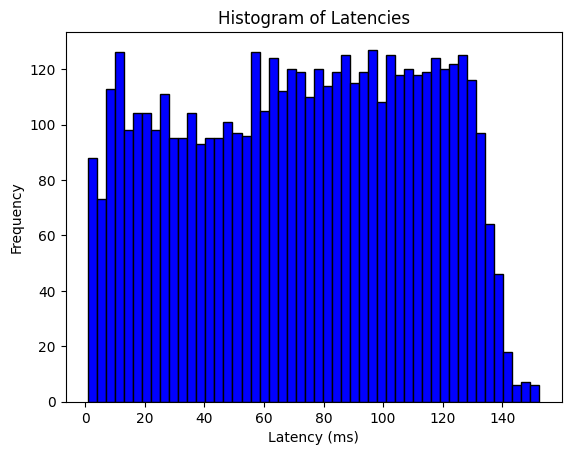

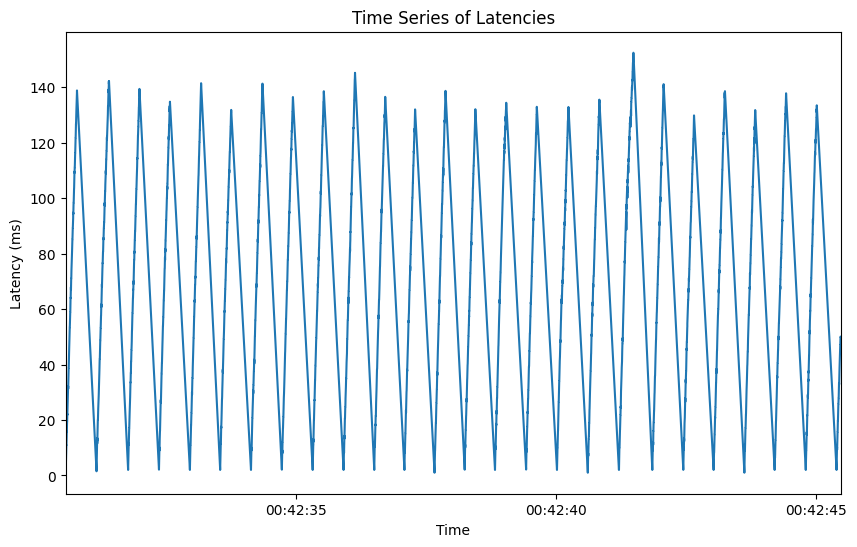

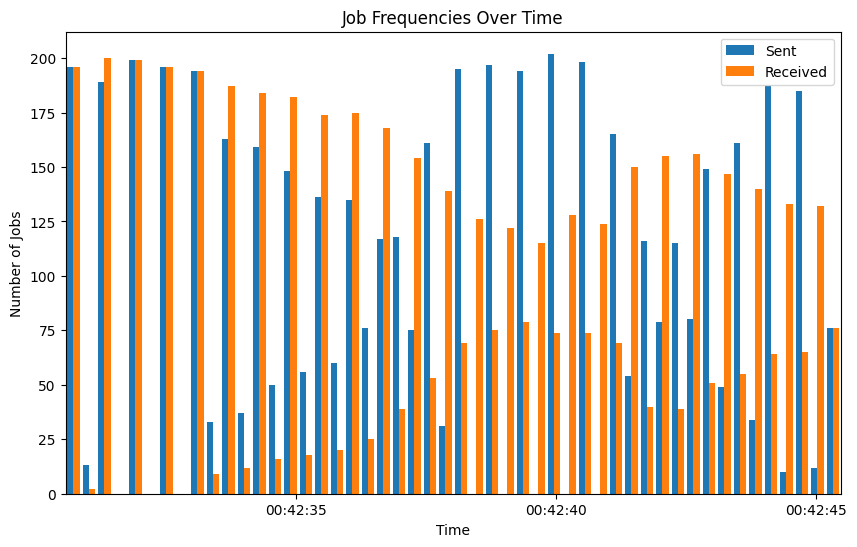

In [15]:
# Plot histogram of latencies
plt.hist(latencies_ms, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Latencies')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()

# Create a list of latencies in milliseconds and the corresponding timestamps
latencies_ms = [latency.total_seconds() * 1000 for latency in latencies.values()]
timestamps = [timestamp for action, _, timestamp in combined_data if action == 'receive']





# Plot the time series of latencies
plt.figure(figsize=(10, 6))
plt.plot(timestamps, latencies_ms)
plt.xlim([start_time, end_time]) 
plt.title('Time Series of Latencies')
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.show()

# Create a list of timestamps for sent and received jobs
timestamps_sent = [timestamp for action, _, timestamp in combined_data if action == 'send']
timestamps_received = [timestamp for action, _, timestamp in combined_data if action == 'receive']

# Create a histogram of job frequencies
plt.figure(figsize=(10, 6))
plt.hist([timestamps_sent, timestamps_received], label=['Sent', 'Received'], bins=50)
plt.xlim([start_time, end_time]) 
plt.title('Job Frequencies Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Jobs')
plt.legend()
plt.show()